#### %pip install segment-geospatial
#### strictly use conda for installing leafmap, localtileserver and jupyter-server-proxy (for connecting remote vscode with localtileserver)
#### conda install conda-forge::jupyter-server-proxy
#### conda install conda-forge::localtileserver
#### conda install conda-forge::leafmap

In [1]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from samgeo.text_sam import LangSAM
from PIL import Image
import rasterio
from rasterio.windows import Window
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()

In [2]:
m = leafmap.Map()
m.add_basemap("SATELLITE")

In [3]:
# m = leafmap.Map(center=(26.932112,81.051197), zoom=20)
# m.add_basemap("SATELLITE")

# if m.user_roi_bounds() is not None:
#     bbox = m.user_roi_bounds()
# else:
#     bbox = [81.050812, 26.931705, 81.051582, 26.932519]

In [4]:
# image = 'output.tif' # download the bbox image and save it in this file
# tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

In [5]:
# image_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_kilns_zoom19/9021406_3115876_1.tif' # zoom 19 kiln
image_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_high_resolution_zoom17/8988385_3137890.tif' # zoom 17 imagery
# image_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images/8988385_3137890.png' # Superresolved imagery
# image_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/images/8988385_3137890.tif' # Planet imagery


# m.layers[-1].visible = True  # turn off the basemap
# m.add_raster(image, layer_name="Image")
# m

In [6]:
# check the latitude and longitude of the original geotiff
from osgeo import gdal
geotiff = gdal.Open(image_path)
metadata = gdal.Info(geotiff)
for line in metadata.split('\n'):
    print(line)

Driver: GTiff/GeoTIFF
Files: /home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_high_resolution_zoom17/8988385_3137890.tif
Size is 2560, 2560
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHO

In [7]:
# # Initialise segmentation model SamGeo
# sam = SamGeo(
#     model_type="vit_h",
#     checkpoint="sam_vit_h_4b8939.pth",
#     sam_kwargs=None,
# )

In [8]:
# mask = "segment.tif"
# sam.generate(
#     image, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
# )

In [9]:
# vector = "segment.gpkg"
# sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

In [10]:
# shapefile = "segment.shp"
# sam.tiff_to_vector(mask, shapefile)

In [11]:
# style = {
#     "color": "#3388ff",
#     "weight": 2,
#     "fillColor": "#7c4185",
#     "fillOpacity": 0.5,
# }
# m.add_vector(vector, layer_name="Vector", style=style)
# m

Initialise Lang Sam class

In [12]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


In [13]:
# Image.open(image_path)

In [14]:
# read the original image and crop a patch, update the patch transform and save it in /tmp
src = rasterio.open(image_path)
window = Window(0, 0, 320,320) # col offset, row offset, width, height
patch = src.read(window=window)
patch_transform = src.window_transform(window)
profile = src.profile
profile.update({
    "height": window.height,
    "width": window.width,
    "transform": patch_transform
})
patch_path = "/tmp/cropped_output.tif"
with rasterio.open(patch_path, "w", **profile) as dst:
        dst.write(patch)
image = Image.open(patch_path)
print(f'Image shape: {image.size}')

Image shape: (320, 320)


In [15]:
# predict on the patch
text_prompt = "brick kiln with chimney"
out = sam.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)

In [16]:
sam.prediction, sam.phrases, sam.source, sam.boxes

(array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0, 255,   0],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255]]),
 ['brick kiln', 'brick kiln', 'chimney'],
 None,
 tensor([[ 1.5583e+02,  3.2799e+01,  2.6174e+02,  1.5613e+02],
         [-1.3561e-02,  1.8730e-02,  3.1998e+02,  3.2002e+02],
         [ 1.5659e+02,  2.1096e+01,  1.7362e+02,  5.4009e+01]]))

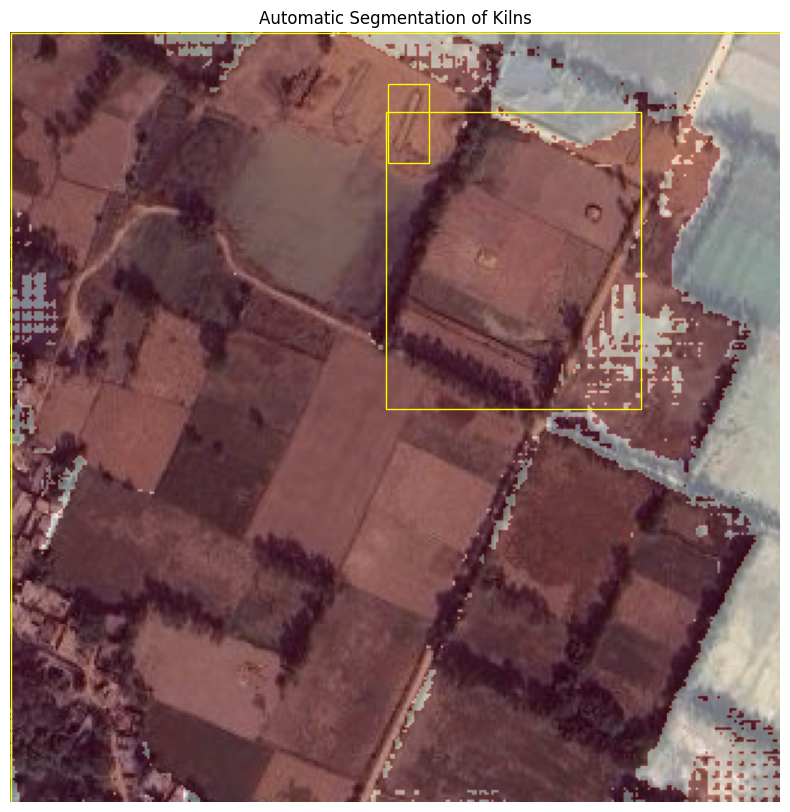

In [17]:
sam.show_anns(
    cmap="Reds",
    box_color="yellow",
    title="Automatic Segmentation of Kilns",
    blend=True,
)

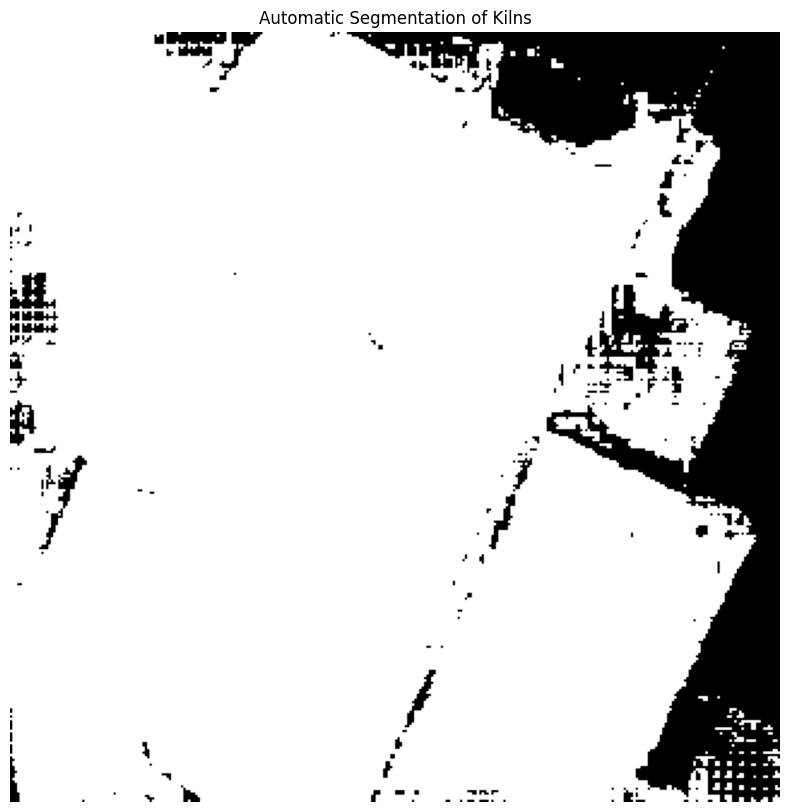

In [18]:
sam.set_image(patch_path) # set the path to image on which segmentation is performed, very important to see the segmentation at correct location
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Kilns",
    blend=False,
    output = 'segment.tif'
)

In [19]:
geotiff = gdal.Open('segment.tif')
metadata = gdal.Info(geotiff)
for line in metadata.split('\n'):
    print(line)

Driver: GTiff/GeoTIFF
Files: segment.tif
Size is 320, 320
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMET

In [20]:
geotiff = gdal.Open(patch_path)
metadata = gdal.Info(geotiff)
for line in metadata.split('\n'):
    print(line)

Driver: GTiff/GeoTIFF
Files: /tmp/cropped_output.tif
Size is 320, 320
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
   

In [21]:
# sam.raster_to_vector("segment.tif", "segment.shp")

In [22]:
# issue https://github.com/opengeos/leafmap/discussions/677
# add port number to connect to localtileserver and forward the port
m.add_raster(patch_path, layer_name="cropped_Image", port = 40001) # add the patch
m.add_raster("segment.tif", layer_name="Kilns", palette ='greens', nodata=0, port = 40001) #add the segment raster

print(m.layers[2].url)
# style = {
#     "color": "#3388ff",
#     "weight": 2,
#     "fillColor": "#7c4185",
#     "fillOpacity": 0.5,
# }
# m.add_vector("segment.shp", layer_name="Vector", style=style) # add the shape file
m

http://127.0.0.1:40001/api/tiles/{z}/{x}/{y}.png?&filename=%2Ftmp%2Fcropped_output.tif


Map(center=[27.126044, 80.7320235], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [25]:
sam.show_map()

Map(center=[27.126044, 80.7320235], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [26]:
# # https://github.com/banesullivan/localtileserver/issues/181

# from localtileserver import get_leaflet_tile_layer, TileClient
# from ipyleaflet import Map, basemaps

# # First, create a tile server from local raster file
# port = 40001
# tile_client = TileClient('segment.tif', port)

# # Create ipyleaflet tile layer from that server
# t = get_leaflet_tile_layer(tile_client)

# # Create ipyleaflet map, add tile layer, and display
# lm = Map(basemap=basemaps.Esri.WorldImagery, center=tile_client.center())
# lm.add_layer(t)
# lm
